This notebook can be used to evaluate the forecast skill (ROC score) for a specific forecast dataset. It currently works for a specific index and a specific issue month as it has a research / exploratory / analytical purpose. In order to run a proper comparison, check the `compare_analytical` notebook. 

In [1]:
import numpy as np

from config.params import Params

from helper_fns import (
    read_forecasts_locally,
    read_observations_locally,
)
from analytical import calculate_forecast_probabilities

from hip.analysis.ops._statistics import evaluate_roc_forecasts

%cd ../

c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
INFO:root:Set disk cache path.


c:\Users\amine.barkaoui\OneDrive - World Food Programme\Documents\GitHub\anticipatory-action


In [2]:
issue = "09"

params = Params(iso='MOZ', index='SPI')

# TODO replace by downscaled forecasts (climax / bil. interp. / weighted mask) issued in 9 (1993 - 2022)
forecasts = read_forecasts_locally(
    f"data/{params.iso}/forecast/Moz_SAB_tp_ecmwf_{issue}/*.nc"
).isel(latitude=slice(0, 32), longitude=slice(0, 32))

forecasts = forecasts.where(
    forecasts.time < np.datetime64(f"{params.year}-07-01T12:00:00.000000000"),
    drop=True,
)

# TODO replace by `rfh_daily`
observations = read_observations_locally(f"data/{params.iso}/chirps").isel(latitude=slice(0, 32), longitude=slice(0, 32))

In [3]:
forecasts

<xarray.Dataset>
Dimensions:    (time: 6155, ensemble: 51, latitude: 32, longitude: 32)
Coordinates:
  * longitude  (longitude) float32 28.12 28.38 28.62 28.88 ... 35.38 35.62 35.88
  * latitude   (latitude) float32 -29.88 -29.62 -29.38 ... -22.62 -22.38 -22.12
  * ensemble   (ensemble) float64 0.0 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0 50.0
  * time       (time) datetime64[ns] 1993-09-01T12:00:00 ... 2022-03-31T12:00:00
Data variables:
    tp         (time, ensemble, latitude, longitude) float32 0.9264 ... 3.796
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Oct 20 09:24:19 2020: cdo -O -L -r -selmon,9,10,11,12,1...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [4]:
observations

<xarray.Dataset>
Dimensions:    (time: 15491, longitude: 32, latitude: 32)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2023-05-31
  * longitude  (longitude) float32 28.12 28.38 28.62 28.88 ... 35.38 35.62 35.88
  * latitude   (latitude) float32 -29.88 -29.62 -29.38 ... -22.62 -22.38 -22.12
Data variables:
    precip     (time, latitude, longitude) float32 0.0 0.0 0.0 ... nan nan nan
Attributes: (12/17)
    CDI:               Climate Data Interface version 1.9.10 (https://mpimet....
    Conventions:       CF-1.6
    institution:       Climate Hazards Group.  University of California at Sa...
    history:           Wed Jul 14 16:25:15 2021: cdo -O -r -L mergetime Remap...
    title:             CHIRPS Version 2.0
    version:           Version 2.0
    ...                ...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ
    CDO:               Climate Data Operators version 1.9.10 (https://mpimet....

In [5]:
period_months = (12, 1, 2) # Dec Jan Feb

probs, probs_bc, obs_values, obs_bool = calculate_forecast_probabilities(
    forecasts,
    observations,
    params,
    period_months,
    issue,
)

INFO:root:Completed accumulation
INFO:root:Completed anomaly
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\

In [6]:
auc, auc_bc = evaluate_roc_forecasts(
    obs_bool.precip,
    probs.tp,
    probs_bc.scen,
)

Average AUC score: 0.6078159053945198


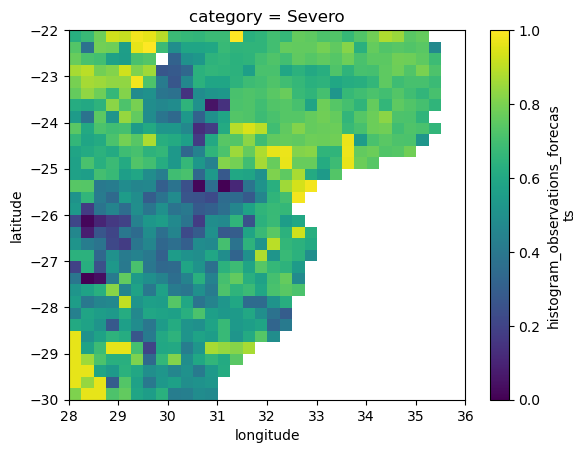

In [13]:
# Without bias correction

print(f"Average AUC score: {auc.sel(category='Severo').mean().values}")
auc.sel(category='Severo').plot.imshow()

Average AUC score: 0.5252887925003847


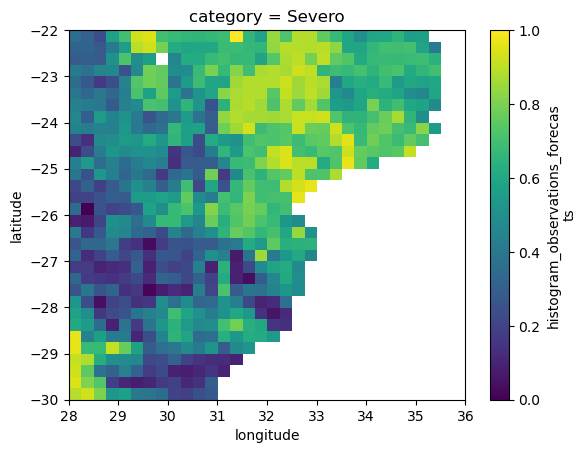

In [14]:
# With bias correction

print(f"Average AUC score: {auc_bc.sel(category='Severo').mean().values}")
auc_bc.sel(category='Severo').plot.imshow()